# Multi Agent Testing

Testing on multi-agent system

Current progress:

Implement the 3 tools the model may use

## Requirements

In [ ]:
!pip install -r sgp_bootcamp_material/project/multi-agent-requirements.txt
!pip install langgraph
!pip install langchain-nvidia-ai-endpoints==0.3.5

In [ ]:
!pip list

## Imports

In [2]:
from IPython.display import Image, display
import getpass, os, base64
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.messages.ai import AIMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from collections.abc import Iterable
from random import randint
from langgraph.prebuilt import InjectedState
from langchain_core.messages.tool import ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults


/home/g05/.local/lib/python3.9/site-packages/langchain_community/tools/tavily_search/__init__.py:3: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_community.tools.tavily_search.tool import (


In [74]:
nvidia_api_key = getpass.getpass("Enter your NVIDIA API key: ")
assert nvidia_api_key.startswith("nvapi-"), f"{nvidia_api_key[:5]}... is not a valid key"
os.environ["NVIDIA_API_KEY"] = nvidia_api_key

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

In [3]:
tvly_api_key = getpass.getpass("Enter your tvly API key: ")
assert tvly_api_key.startswith("tvly-"), f"{tvly_api_key[:5]}... is not a valid key"
os.environ["TAVILY_API_KEY"] = tvly_api_key

Enter your tvly API key:  ········


## Reference Scripts

https://www.kaggle.com/code/lejieng/day-3-building-an-agent-with-langgraph

### Core Instructions

In [4]:
class Conversation(TypedDict):
    """State representing the customer's conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # Flag indicating that the order is placed and completed.
    finished: bool
    
# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
SYSTEM_INSTRUCTIONS = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are a Legal Advice Chat Bot, you provide users with concise, accurate, and Singapore-specific legal information and guidance related to business operations, compliance, and regulations. "
    "A human will ask you about any questions they regarding the legal domain relating to business and you will answer any questions "
    "they have (and only about questions in the legal domain regarding business - no off topic discussions) "
    "Only provide legal information relevant to Singapore’s business laws, corporate regulations, and compliance requirements. "
    "Avoid discussing laws or business practices from other jurisdictions unless explicitly asked for comparison, and clarify that it is outside Singapore's context."
    "\n\n"
    "Provide general guidance on topics such as company incorporation, employment regulations, tax compliance, intellectual property (IP), contract law, and data protection in Singapore."
    "Avoid offering personalized legal advice, contract drafting, or reviews. Encourage users to consult qualified professionals for specific situations."
    "\n\n"
    "Business-specific topics include: Company incorporation and legal structures (e.g., Sole Proprietorship, LLP, Pte Ltd), "
    "Employment regulations under the Employment Act, "
    "Tax compliance (e.g., GST registration, corporate income tax), "
    "Licensing and permits for businesses, "
    "Data privacy laws, including compliance with the Personal Data Protection Act (PDPA), "
    "Commercial contract fundamentals and enforceability, "
    "and IP rights, including trademarks, copyrights, and patents in Singapore."
    "\n\n"
    "Use straightforward, business-friendly language. "
    "Explain legal concepts with examples or simplified analogies when possible. "
    "Provide links to official Singapore government resources (e.g., ACRA, IRAS, MOM) where applicable. "
    "\n\n"
    "Ensure responses are aligned with the latest Singaporean laws, regulations, and best practices. "
    "If unsure of current laws, advise users to verify with government authorities or legal experts. "
    "\n\n"
    "Do not provide guidance that could facilitate illegal activities or tax evasion. "
    "Avoid speculating on outcomes of legal disputes or offering advice that requires knowledge of specific business circumstances. "
    "\n\n"
    "Politely decline if a query falls outside Singapore’s legal context or business-related scope. Redirect users to appropriate resources or professionals. "
    "Clearly state when information is general and not a substitute for professional legal counsel. "
    "\n\n"
    'Examples of Accepted Queries: Topics the bot can assist with include "How do I register a private limited company in Singapore?" "What are the requirements for hiring foreign employees?" "Do I need to register for GST if my business turnover exceeds $1 million?" and "What steps should I take to trademark my business logo?"'
    'Examples of Declined Queries: Requests such as “Can you draft a shareholders’ agreement for me?” or “What are corporate tax laws in Hong Kong?” will be declined politely, with users advised to consult professionals or explore suitable external resources. Similarly, unethical queries, such as “How can I avoid CPF contributions for employees?” will be met with a clear explanation of the legal obligations in Singapore.'
    "\n\n"
    "Remember to provide citation to any information you provide to the user. "
    "If the information you retrieve is old, please fact chat the information with more recent sources to ensure the information is accurate. "
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to the ASPER LOVERS LEGAL Bot. Type `q` to quit. How may I serve you today?"

### LLM Model

In [13]:
# mistral hates me
# we ball with llama3.1-405b instruct
llm = ChatNVIDIA(model="meta/llama-3-8b-instruct", base_url="http://localhost:8000/v1")

### Nodes

In [14]:
def human_node(state: Conversation) -> Conversation:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}

def chatbot_with_tools(state: Conversation) -> Conversation:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"order": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([SYSTEM_INSTRUCTIONS] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return defaults | state | {"messages": [new_output]}

def maybe_exit_human_node(state: Conversation) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"
    
def maybe_route_to_tools(state: Conversation) -> Literal["tools", "human"]:
    """Route between human or tool nodes, depending if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]

    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "human"

### Tools

#### VLM setup??


In [7]:
# VLM setup
# %pip uninstall torch torchvision torchaudio -y
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install git+https://github.com/huggingface/transformers@aae496dd154f72242a7d6ebeca132763d3dbc903 accelerate # this specific commit, not the latest for whatever reason?? idk i just plucked from the issue and PR
%pip install qwen-vl-utils[decord]
%pip uninstall -y tensorflow && pip install tensorflow-cpu

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu121

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/huggingface/transformers (to revision aae496dd154f72242a7d6ebeca132763d3dbc903) to /tmp/pip-req-build-zpdwjq3l
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-zpdwjq3l
  Running command git rev-parse -q --verify 'sha^aae496dd154f72242a7d6ebeca132763d3dbc903'
  Running command git fetch -q https://github.com/huggingface/transformers aae496dd154f72242a7d6ebeca132763d3dbc903
  Running command git checkout -q aae496dd154f72242a7d6ebeca132763d3dbc903
  Resolved https://github.com/huggingface/transformers to

In [15]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

class QwenVLM:
    def __init__(self):
        # default: Load the model on the available device(s)
        self.model = Qwen2VLForConditionalGeneration.from_pretrained(
            "Qwen/Qwen2-VL-7B-Instruct", torch_dtype="auto", device_map="auto"
        )

        self.processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

    # The default range for the number of visual tokens per image in the model is 4-16384.
    # You can set min_pixels and max_pixels according to your needs, such as a token range of 256-1280, to balance performance and cost.
    # min_pixels = 256*28*28
    # max_pixels = 1280*28*28
    # processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)
    @tool
    def invoke_tool(prompt):
        """
        Invokes call to model residing in local memory, see if we can serve elsewhere 
        """
        
        return self.invoke(prompt)
    
    def invoke(prompt):
        messages = [
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "image": "sgp_bootcamp_material/project/DB/test2.png",
                    },
                    {
                        "type": "text",
                        "text": "Describe the contents of this image."
                    },
                ],
            }
        ]

        # Preparation for inference
        text = processor.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        image_inputs, video_inputs = process_vision_info(messages)
        inputs = self.processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt",
        )
        inputs = inputs.to("cuda")

        # Inference: Generation of the output
        generated_ids = self.model.generate(**inputs, max_new_tokens=8196)
        generated_ids_trimmed = [
            out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]
        output_text = self.processor.batch_decode(
            generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
        )
        
        return output_text

In [16]:
@tool
def RAG_FROM_DATABASE():
    """Tool for searching through database to search for prior ingested information
    
    Returns:
        PLACEHOLDER: The prior ingested information
    """
    PLACEHOLDER = """Everything is Illegal"""
    
    return PLACEHOLDER

# @tool
# def SEARCH_INTERNET():
#     """Tool for searching the internet in the event no relevant information can be found in ingested information database
    
#     Returns:
#         PLACEHOlDER: Internet Information
#     """
#     PLACEHOLDER = TavilySearchResults(max_results=1)
    
#     return PLACEHOLDER

### Define Tools

In [17]:
# Define the tools and create a "tools" node.
# tools = [USE_VLM, RAG_FROM_DATABASE, SEARCH_INTERNET]
qwen = QwenVLM()
tools = [qwen.invoke_tool, RAG_FROM_DATABASE, TavilySearchResults(max_results=1)]
tool_node = ToolNode(tools)

# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

### Graphs

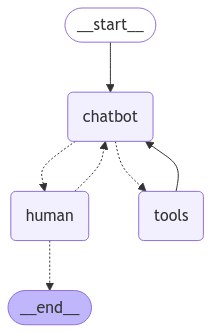

In [18]:
graph_builder = StateGraph(Conversation)

# Add the nodes, including the new tool_node.
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human may go back to chatbot, or exit.
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")
test_graphs = graph_builder.compile()

Image(test_graphs.get_graph().draw_mermaid_png())

In [19]:
state = test_graphs.invoke({"messages": []})

Model: Welcome to the ASPER LOVERS LEGAL Bot. Type `q` to quit. How may I serve you today?
User:  i love balls


Exception: [###] Unknown Error
{'object': 'error', 'message': 'The model `meta/llama-3-8b-instruct` does not exist.', 'type': 'NotFoundError', 'param': None, 'code': 404}

In [20]:
llm.generate("nigeria")

TypeError: Got unknown type n

In [106]:
for chunk in state['messages']:
    chunk.pretty_print()

================================== Ai Message ==================================

Welcome to the ASPER LOVERS LEGAL Bot. Type `q` to quit. How may I serve you today?
================================ Human Message =================================

can you call the vlm tool for debug purposes
================================== Ai Message ==================================
Tool Calls:
  USE_VLM (chatcmpl-tool-8e914b41695e49d49d51cad361bbacbb)
 Call ID: chatcmpl-tool-8e914b41695e49d49d51cad361bbacbb
  Args:
================================= Tool Message =================================
Name: USE_VLM

content="I'm sorry, but I am unable to view images or screenshots. I can only process text or provide information based on prompts and my programming. Is there something specific you would like to know or talk about?" additional_kwargs={} response_metadata={'role': 'assistant', 'content': "I'm sorry, but I am unable to view images or screenshots. I can only process text or provide informatio